In [12]:
import os
import tqdm.autonotebook as tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from multiprocessing.pool import ThreadPool
from collections import deque

import util

%matplotlib inline

In [2]:
data_read = pd.read_csv(util.trainLabels)

In [3]:
data_read.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


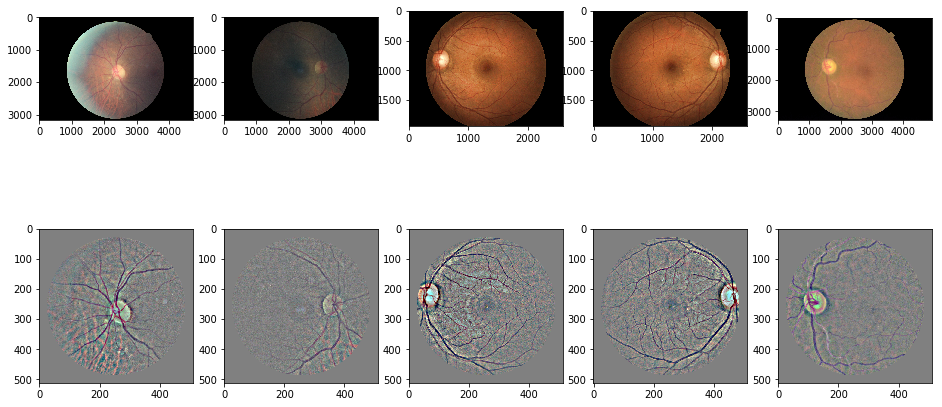

In [8]:
fig, ax = plt.subplots(2, len(data_read.head()), figsize = (16, 8))

def get_radius(img, scale):
    x = img[int(img.shape[0]/2),:,:].sum(1)
    return (x>x.mean()/10).sum()/2

scale = 256

for idx in range(len(data_read.head())):
    img_path = util.train_path+data_read['image'][idx]+'.jpeg'
    img = cv2.imread(img_path)
    
    # Get Eye Radius
    r = get_radius(img, scale)
    # cv2.circle(img, (int(img.shape[1]/2),int(img.shape[0]/2)), int(r*0.9), (255,255,255), 50, 8, 0)
    ax[0, idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    # Resize
    s = scale*1.0/r
    img = cv2.resize(img, (0,0), fx=s, fy=s)
    
    # High pass filter and blurr the edges
    c_x, c_y = int(img.shape[1]/2),int(img.shape[0]/2)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), scale/30), -4, 128)
    mask = np.zeros(img.shape)
    cv2.circle(mask, (c_x, c_y), int(scale*0.9), (1,1,1), -1, 8, 0)
    img = (img.astype(np.float)*mask+128*(1-mask)).astype(np.uint8)
    
    # Final Crop
    img_r = 128*np.ones((2*scale, 2*scale, 3), dtype=np.uint8)
    # img_r = np.zeros((2*scale, 2*scale, 3), dtype=np.uint8)
    h, w = min(scale, c_y), min(scale, c_x) 
    img_r[scale-h:scale+h, scale-w:scale+w, :] = img[c_y-h:c_y+h, c_x-w:c_x+w, :]
    ax[1, idx].imshow(cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB))

In [18]:
def preprocess_img(filename, img_class, in_dir, out_dir, edge=False, scale = 256):
    try:
        rd_path = in_dir+filename+'.jpeg'
        img = cv2.imread(rd_path)

        # Get Eye Radius
        r = get_radius(img, scale)

        # Resize
        s = scale*1.0/r
        img = cv2.resize(img, (0,0), fx=s, fy=s)

        # High pass filter and blurr the edges
        c_x, c_y = int(img.shape[1]/2),int(img.shape[0]/2)
        if edge:
            img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), scale/30), -4, 128)
            mask = np.zeros(img.shape)
            cv2.circle(mask, (c_x, c_y), int(scale*0.9), (1,1,1), -1, 8, 0)
            img = (img.astype(np.float)*mask+128*(1-mask)).astype(np.uint8)

        # Final Crop
        if edge:
            img_r = 128*np.ones((2*scale, 2*scale, 3), dtype=np.uint8)
        else:
            img_r = np.zeros((2*scale, 2*scale, 3), dtype=np.uint8)
        h, w = min(scale, c_y), min(scale, c_x) 
        img_r[scale-h:scale+h, scale-w:scale+w, :] = img[c_y-h:c_y+h, c_x-w:c_x+w, :]

        wr_path = out_dir+"/%d/" % img_class+filename+'.jpeg'
        cv2.imwrite(wr_path, img_r)
        return None
    except KeyboardInterrupt:
        raise
    except:
        return filename

In [19]:
out_base_path = util.dataset_base+"/preprocess"
edge = False

if not os.path.isdir(out_base_path):
    os.mkdir(out_base_path)

out_path = out_base_path+("/train_filter" if edge else "/train_crop")
if not os.path.isdir(out_path):
    os.mkdir(out_path)
        
for n in range(5):
    class_path = out_path+"/%d" % n
    if not os.path.isdir(class_path):
        os.mkdir(class_path)

        
threadn = cv2.getNumberOfCPUs()-2
pool = ThreadPool(processes = threadn)
pending = deque()

num_tasks = len(data_read)
n_in, n_out = 0, 0

pbar = tqdm.tqdm(total=num_tasks)
while n_out < num_tasks:
    while len(pending) > 0 and pending[0].ready():
        result = pending.popleft().get()
        if result is not None:
            print(result)
        n_out += 1
        pbar.update(1)
    if len(pending) < threadn and n_in < num_tasks:
        task = pool.apply_async(preprocess_img, (data_read.image[n_in], data_read.level[n_in], util.train_path, out_path, edge))
        pending.append(task)
        n_in += 1
pbar.close()

C:\Users\Chiraag\Anaconda3\envs\gazelle\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


492_right


In [135]:
data_read.image[0]

'10_left'

In [ ]:
ValueError